In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision
import matplotlib.pyplot as plt

In [2]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [3]:
class MNSIT(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(1,128,3,1,1)
        self.conv2 = nn.Conv2d(128,128,3,1,1)
        self.linear1 = nn.Linear(1152,256)
        self.linear2 = nn.Linear(256,10)
        self.drop1 = nn.Dropout2d(p=0.3)
        self.drop2 = nn.Dropout(p=0.75)
        self.maxpool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
    
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.drop1(x)
        
        x = self.conv2(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.drop1(x)
        
        x = self.conv2(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.drop1(x)
        
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.drop2(x)
        x = self.linear2(x)
        
        return x

In [4]:
model = MNSIT().cuda()
for param_names,param in model.named_parameters():
    print(param_names)

conv1.weight
conv1.bias
conv2.weight
conv2.bias
linear1.weight
linear1.bias
linear2.weight
linear2.bias


In [5]:
summary(model=model,input_size=(1,28,28),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
            Conv2d-2          [-1, 128, 28, 28]         147,584
              ReLU-3          [-1, 128, 28, 28]               0
         MaxPool2d-4          [-1, 128, 14, 14]               0
         Dropout2d-5          [-1, 128, 14, 14]               0
            Conv2d-6          [-1, 128, 14, 14]         147,584
            Conv2d-7          [-1, 128, 14, 14]         147,584
              ReLU-8          [-1, 128, 14, 14]               0
         MaxPool2d-9            [-1, 128, 7, 7]               0
        Dropout2d-10            [-1, 128, 7, 7]               0
           Conv2d-11            [-1, 128, 7, 7]         147,584
           Conv2d-12            [-1, 128, 7, 7]         147,584
             ReLU-13            [-1, 128, 7, 7]               0
        MaxPool2d-14            [-1, 12

In [6]:
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=False,
                                          transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.1307,), (0.3081,)).cuda()])),batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=False,
                                          transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.1307,), (0.3081,)).cuda()])),batch_size=100, shuffle=True)

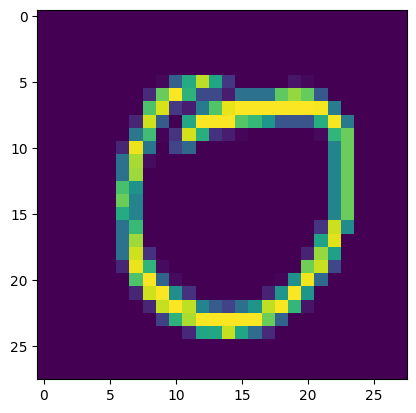

In [7]:
for data,target in test_loader:
    plt.imshow(data[0][0])

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

In [9]:
from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    print("{}/{}".format(accuracy,total))
    accuracy = float(100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = images.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=False)
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_function(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %.2f %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [10]:
train(20)

The model will be running on cuda:0 device
[1,  1000] loss: 0.759
9743.0/10000.0
For epoch 1 the test accuracy over the whole test set is 97.43 %
[2,  1000] loss: 0.073
9871.0/10000.0
For epoch 2 the test accuracy over the whole test set is 98.71 %
[3,  1000] loss: 0.045


KeyboardInterrupt: 